Author: Shan Qu, Delft University of Technology

First created: 4 April 2021; latest modifed: 7 April 2021

Product: credit modeling --- training the model using XGBoost


In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv, DMatrix

%run helpers.ipynb

pd.set_option('display.max_columns', 20)
seed = 143

import warnings
warnings.filterwarnings("ignore")

model = XGBClassifier()

In [2]:
df_X_train = pd.read_csv('Data/df_X_train.csv')
df_X_val = pd.read_csv('Data/df_X_val.csv')
df_y_train = pd.read_csv('Data/df_y_train.csv')
df_y_val = pd.read_csv('Data/df_y_val.csv')
print(df_X_train.info())
print(df_y_train.info())

# drop the unnamed ID column
df_X_train.drop('Unnamed: 0', axis=1, inplace=True)
df_X_val.drop('Unnamed: 0', axis=1, inplace=True)
df_y_train.drop('Unnamed: 0', axis=1, inplace=True)
df_y_val.drop('Unnamed: 0', axis=1, inplace=True)

df_X_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         506 non-null    int64  
 1   duration           506 non-null    float64
 2   credit_amount      506 non-null    float64
 3   installment_rate   506 non-null    float64
 4   residence_length   506 non-null    float64
 5   age                506 non-null    float64
 6   existing_credits   506 non-null    float64
 7   liable_people      506 non-null    float64
 8   checking_account   506 non-null    float64
 9   credit_history     506 non-null    float64
 10  purpose            506 non-null    float64
 11  savings_account    506 non-null    float64
 12  employment_length  506 non-null    float64
 13  status_sex         506 non-null    float64
 14  other_debtors      506 non-null    float64
 15  property           506 non-null    float64
 16  installment_plan   506 non

,duration,credit_amount,installment_rate,residence_length,age,existing_credits,liable_people,checking_account,credit_history,purpose,savings_account,employment_length,status_sex,other_debtors,property,installment_plan,housing,job,telephone,foreign_worker
0,0.294118,0.269616,1.0,1.000000,0.250000,0.000000,0.0,0.0,0.000000,0.636409,1.000000,0.157661,0.000000,0.436055,0.424937,0.0,0.0,0.235904,0.0,1.0
1,0.647059,0.687741,1.0,0.000000,0.321429,0.000000,0.0,0.0,0.324712,0.335297,0.211197,0.000000,0.000000,0.436055,0.424937,0.0,0.0,1.000000,0.0,1.0
2,0.470588,0.155662,1.0,1.000000,0.303571,0.000000,0.0,0.0,0.326222,0.818572,0.212304,0.452020,0.000000,0.436055,0.000000,0.0,0.0,0.235904,1.0,1.0
3,0.073529,0.048861,1.0,1.000000,0.107143,0.333333,0.0,1.0,0.000000,0.335297,1.000000,0.452020,0.000000,0.436055,0.000000,0.0,0.0,0.000000,1.0,1.0
4,0.088235,0.035435,1.0,0.666667,0.375000,0.000000,0.0,0.0,0.326222,0.000000,0.212304,0.000000,0.637758,0.436055,0.419563,0.0,0.0,0.235904,0.0,1.0


## 3. Credit modeling

#### 3.1 Tune hyperparameters

**Tune XGBoost hyperparameters step by step:**

Choose a relatively high learning rate (0.1). Determine the optimum number of trees for this learning rate.

Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees.

Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

Lower the learning rate and decide the optimal parameters.

Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

0.8359683794466403
0.9177459419769096
42


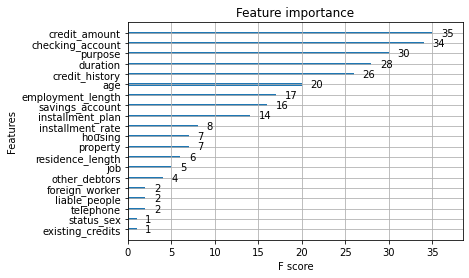

In [3]:
# Tune n_estimators
model = XGBClassifier(learning_rate = 0.1)
Dtrain = DMatrix(df_X_train.values, label=df_y_train.values)
cvresult = cv(model.get_xgb_params(), Dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
              metrics='auc', early_stopping_rounds=50)

model.set_params(n_estimators=cvresult.shape[0])
model.fit(df_X_train, df_y_train, eval_metric='auc')
        
preds = model.predict(df_X_train)
preds_prob = model.predict_proba(df_X_train)[:,1]
        
print(accuracy_score(df_y_train.values, preds))
print(roc_auc_score(df_y_train, preds_prob))
print(model.get_params()['n_estimators'])       

plot_importance(model, importance_type = 'weight')
plt.show()


In [4]:
# Tune max_depth, min_child_weight
model = XGBClassifier(learning_rate = 0.1, n_estimators=42)
hyperparam_grid_1 = {'max_depth': range(3,20,2),
                     'min_child_weight': range(1,7,2)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)


Fitting 15 folds for each of 27 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7897362552864283
{'max_depth': 5, 'min_child_weight': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   17.5s finished


In [5]:
# Fine tune max_depth, min_child_weight
model = XGBClassifier(learning_rate = 0.1, n_estimators=42)
hyperparam_grid_1 = {'max_depth': [3, 4, 5, 6, 7],
                     'min_child_weight': [1, 2, 3]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 15 candidates, totalling 225 fits
0.7897362552864283
{'max_depth': 5, 'min_child_weight': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    7.6s finished


In [6]:
# Tune gamma
model = XGBClassifier(learning_rate = 0.1, n_estimators=42, 
                      max_depth = 5, min_child_weight = 1)
hyperparam_grid_2 = {'gamma': np.arange(0, 0.8, 0.02)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_2, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 40 candidates, totalling 600 fits
0.792651287966167
{'gamma': 0.4}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   20.6s finished


In [7]:
# Tune subsample, colsample_bytree
model = XGBClassifier(learning_rate = 0.1, n_estimators=42, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.4)
hyperparam_grid_3 = {'subsample': np.arange(0.5, 1, 0.1),
                     'colsample_bytree': np.arange(0.5, 1, 0.1)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_3, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 25 candidates, totalling 375 fits
0.7901437908496731
{'colsample_bytree': 0.8999999999999999, 'subsample': 0.7999999999999999}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8999999999999999,
              gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7999999999999999, verbosity=1)


[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   12.3s finished


In [8]:
# Fine tune subsample, colsample_bytree
model = XGBClassifier(learning_rate = 0.1, n_estimators=42, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.4)
hyperparam_grid_3 = {'subsample': np.arange(0.7, 0.9, 0.05),
                     'colsample_bytree': np.arange(0.8, 1, 0.05)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_3, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 20 candidates, totalling 300 fits
0.7901437908496731
{'colsample_bytree': 0.9000000000000001, 'subsample': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9000000000000001,
              gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   10.6s finished


In [9]:
# Tune reg_alpha
model = XGBClassifier(learning_rate = 0.1, n_estimators=42, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.4, 
                      colsample_bytree = 0.9, subsample = 0.8)
hyperparam_grid_4 = {'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_4, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 6 candidates, totalling 90 fits
0.7901437908496731
{'reg_alpha': 0}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.0s finished


In [10]:
# Tune learning_rate
model = XGBClassifier(learning_rate = 0.1, n_estimators=42, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.4, 
                      colsample_bytree = 0.9, subsample = 0.8,
                      reg_alpha = 0)
hyperparam_grid_5 = {'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_5, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 5 candidates, totalling 75 fits
0.7901437908496731
{'learning_rate': 0.1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    2.7s finished


In [11]:
model_bestparam = XGBClassifier(learning_rate = 0.1, n_estimators=42, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.4, 
                      colsample_bytree = 0.9, subsample = 0.8,
                      reg_alpha = 0)
model_bestparam.fit(df_X_train, np.ravel(df_y_train))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=42, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

### 3.2 Fit the model using the selected hyperparameters and predict PD using the validation data

[[85 68]
 [ 4 43]]
              precision    recall  f1-score   support

        good       0.96      0.56      0.70       153
         bad       0.39      0.91      0.54        47

    accuracy                           0.64       200
   macro avg       0.67      0.74      0.62       200
weighted avg       0.82      0.64      0.67       200

0.735224586288416


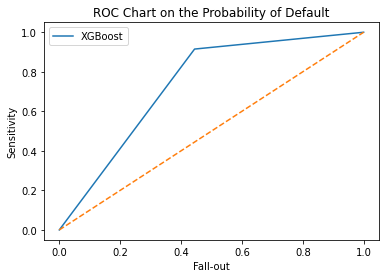

In [12]:
preds = model_bestparam.predict_proba(df_X_val)
df_preds = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.35
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds['Risk_pred']))
print(classification_report(df_y_val, df_preds['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds['Risk_pred']))

plot_roc_PD(df_preds['Risk_pred'], df_y_val, 'XGBoost')
plt.show()

### 3.3 Select proper threshold
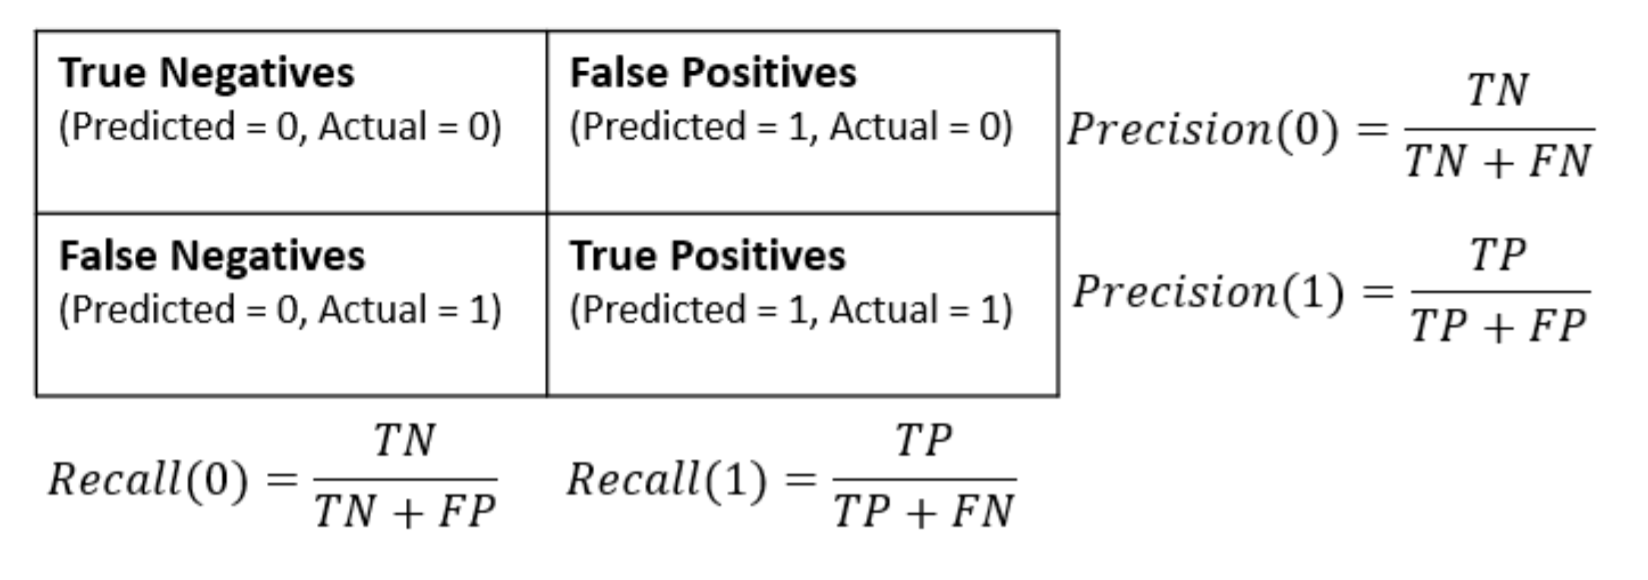

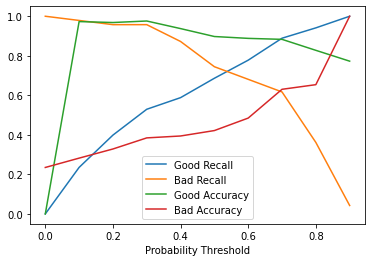

threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management


In [13]:
plot_prob_thresh(df_preds, df_y_val)
plt.show()

print("threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management")

### 3.4 Feature selection using feature_importances of the trained XGBoost

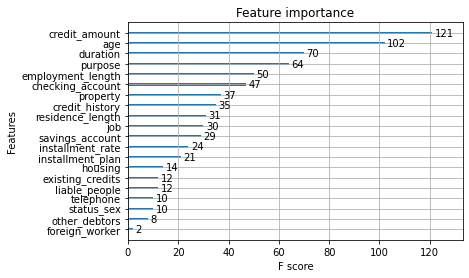

['checking_account', 'purpose', 'age', 'duration', 'job', 'installment_rate', 'installment_plan', 'credit_history', 'credit_amount', 'savings_account', 'employment_length', 'property', 'residence_length', 'housing']
14


In [14]:
plot_importance(model_bestparam, importance_type = 'weight')
plt.show()
#print(model_bestparam.get_booster().get_score(importance_type = 'weight'))

dict_importance = [model_bestparam.get_booster().get_score(importance_type = 'weight')]
df_importance = pd.DataFrame(dict_importance)

selected_columns = []
for index in np.arange(len(df_importance.columns)):
  if df_importance.iloc[0, index] >= 14:
    selected_columns.append(df_importance.columns[index])

print(selected_columns)
print(len(selected_columns))
df_X_train_selected = df_X_train[selected_columns]
df_X_val_selected = df_X_val[selected_columns]

### 3.5 Re-tune the hyperparameters using selected features

0.8735177865612648
0.9597556593604024
100


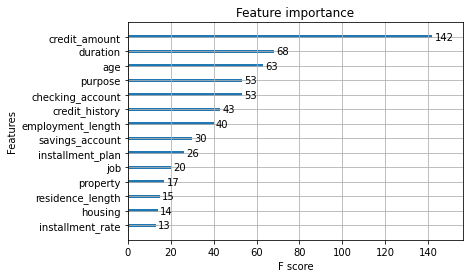

In [17]:
# Tune n_estimators
model = XGBClassifier(learning_rate = 0.1)
Dtrain = DMatrix(df_X_train_selected.values, label=df_y_train.values)

cvresult = cv(model.get_xgb_params(), Dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5, 
              metrics='auc', early_stopping_rounds=50)

model.set_params(n_estimators=cvresult.shape[0])
model.fit(df_X_train_selected, df_y_train, eval_metric='auc')
        
preds = model.predict(df_X_train_selected)
preds_prob = model.predict_proba(df_X_train_selected)[:,1]
        
print(accuracy_score(df_y_train.values, preds))
print(roc_auc_score(df_y_train, preds_prob))
print(model.get_params()['n_estimators'])       

plot_importance(model, importance_type = 'weight')
plt.show()


In [18]:
# Tune max_depth, min_child_weight
model = XGBClassifier(learning_rate = 0.1, n_estimators=100)
hyperparam_grid_1 = {'max_depth': range(3,20,2),
                     'min_child_weight': range(1,7,2)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)


Fitting 15 folds for each of 27 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7828624887863641
{'max_depth': 5, 'min_child_weight': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   29.2s finished


In [19]:
# Fine tune max_depth, min_child_weight
model = XGBClassifier(learning_rate = 0.1, n_estimators=100)
hyperparam_grid_1 = {'max_depth': [3, 4, 5, 6, 7],
                     'min_child_weight': [1, 2, 3]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 15 candidates, totalling 225 fits
0.7828624887863641
{'max_depth': 5, 'min_child_weight': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   12.8s finished


In [20]:
# Tune gamma
model = XGBClassifier(learning_rate = 0.1, n_estimators=100, 
                      max_depth = 5, min_child_weight = 1)
hyperparam_grid_2 = {'gamma': np.arange(0, 0.8, 0.02)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_2, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 40 candidates, totalling 600 fits
0.7851554530308856
{'gamma': 0.76}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.76,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   34.6s finished


In [21]:
# Tune subsample, colsample_bytree
model = XGBClassifier(learning_rate = 0.1, n_estimators=100, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.76)
hyperparam_grid_3 = {'subsample': np.arange(0.5, 1, 0.1),
                     'colsample_bytree': np.arange(0.5, 1, 0.1)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_3, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 25 candidates, totalling 375 fits
0.7807422786107908
{'colsample_bytree': 0.6, 'subsample': 0.8999999999999999}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.76,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8999999999999999, verbosity=1)


[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   20.4s finished


In [22]:
# Fine tune subsample, colsample_bytree
model = XGBClassifier(learning_rate = 0.1, n_estimators=100, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.76)
hyperparam_grid_3 = {'subsample': np.arange(0.7, 0.9, 0.05),
                     'colsample_bytree': np.arange(0.4, 0.7, 0.05)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_3, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 30 candidates, totalling 450 fits
0.7821099577085736
{'colsample_bytree': 0.45, 'subsample': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0.76,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   21.7s finished


In [23]:
# Tune reg_alpha
model = XGBClassifier(learning_rate = 0.1, n_estimators=100, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.76, 
                      colsample_bytree = 0.45, subsample = 0.8)
hyperparam_grid_4 = {'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_4, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 6 candidates, totalling 90 fits
0.782249903883122
{'reg_alpha': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0.76,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.8s finished


In [24]:
# Tune reg_alpha
model = XGBClassifier(learning_rate = 0.1, n_estimators=100, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.76, 
                      colsample_bytree = 0.45, subsample = 0.8)
hyperparam_grid_4 = {'reg_alpha': np.arange(0.5, 1.5, 0.05)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_4, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 20 candidates, totalling 300 fits
0.783437139561707
{'reg_alpha': 0.8500000000000003}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0.76,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.8500000000000003, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   13.8s finished


In [25]:
# Tune learning_rate
model = XGBClassifier(learning_rate = 0.1, n_estimators=100, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.76, 
                      colsample_bytree = 0.45, subsample = 0.8,
                      reg_alpha = 0.85)
hyperparam_grid_5 = {'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_5, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 5 candidates, totalling 75 fits
0.7873994617454826
{'learning_rate': 0.05}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0.76,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.85, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.6s finished


In [26]:
model_bestparam_selected = XGBClassifier(learning_rate = 0.05, n_estimators=100, 
                      max_depth = 5, min_child_weight = 1,
                      gamma = 0.76, 
                      colsample_bytree = 0.45, subsample = 0.8,
                      reg_alpha = 0.85)
model_bestparam_selected.fit(df_X_train_selected, np.ravel(df_y_train))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0.76,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.85, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

[[83 70]
 [ 3 44]]
              precision    recall  f1-score   support

        good       0.97      0.54      0.69       153
         bad       0.39      0.94      0.55        47

    accuracy                           0.64       200
   macro avg       0.68      0.74      0.62       200
weighted avg       0.83      0.64      0.66       200

0.7393269364483382


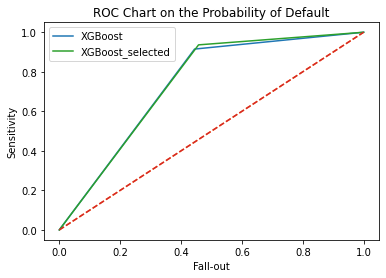

it seems that feature selection is not very effective.


In [27]:
preds = model_bestparam_selected.predict_proba(df_X_val_selected)
df_preds_selected = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.35
df_preds_selected['Risk_pred'] = df_preds_selected['prob_default'].apply(lambda x: 1 if x > threshold else 0)
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds_selected['Risk_pred']))
print(classification_report(df_y_val, df_preds_selected['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds_selected['Risk_pred']))

plot_roc_PD(df_preds['Risk_pred'], df_y_val, 'XGBoost')
plot_roc_PD(df_preds_selected['Risk_pred'], df_y_val, 'XGBoost_selected')
plt.show()


print("it seems that feature selection is not very effective.")

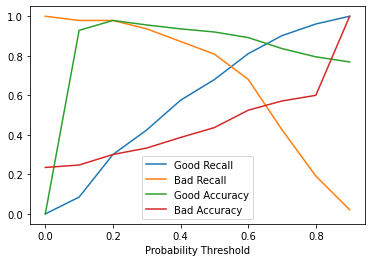

threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management


In [28]:
plot_prob_thresh(df_preds_selected, df_y_val)
plt.show()

print("threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management")

### 3.6 Save the predicted validation data for comparision

In [29]:
df_preds.to_csv('df_preds_XGBoost.csv')